In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2 as cv
import numpy as np
import math

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, BatchNormalization, Activation, Add, ZeroPadding2D,AveragePooling2D
from tensorflow.keras.preprocessing.image import load_img,img_to_array

2024-11-04 01:53:10.630394: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-04 01:53:10.726912: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-04 01:53:10.753944: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-04 01:53:10.884538: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-04 01:53:12.935420: W tensorflow/compiler/tf2

In [3]:
!nvidia-smi

Mon Nov  4 01:53:14 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 565.51.01              Driver Version: 565.90         CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4070        On  |   00000000:01:00.0  On |                  N/A |
|  0%   41C    P8             14W /  200W |    1704MiB /  12282MiB |     11%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Sample Image To Track Progress Through Pipeline

In [4]:
SAMPLE_IMAGE = 'dog.0.jpg'

Image Dimensions: (1, 800, 800, 3)


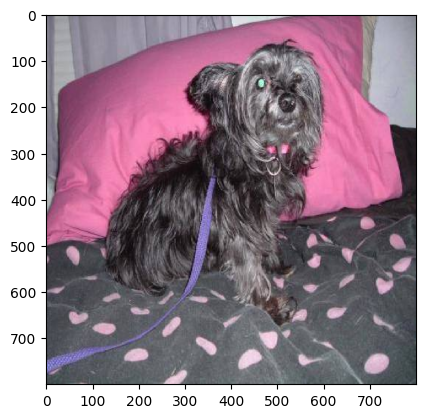

In [5]:
img_pre = load_img(SAMPLE_IMAGE,target_size=(800,800))
img_pre = img_to_array(img_pre)
img_pre = np.divide(img_pre,255.0)
plt.imshow(img_pre)
img_pre = np.expand_dims(img_pre,axis=0)
print(f'Image Dimensions: {img_pre.shape}')

# Steps for Faster R-CNN Architecture

1. **Create Backbone Network**
   - Select a pre-trained CNN (e.g., VGG16, ResNet) for feature extraction.
2. **Generate Region Proposals with RPN**
   - Define anchor boxes of various sizes and aspect ratios.
   - Use a CNN to predict objectness scores and refine anchor box coordinates.
   - Compute RPN loss (classification and regression).

3. **RoI Pooling Layer**
   - Select top N region proposals from RPN.
   - Apply RoI pooling to transform proposals into fixed-size feature maps.

4. **Classification and Bounding Box Regression**
   - Pass pooled features through fully connected layers.
   - Predict object classes and bounding box offsets.
   - Compute classification and regression loss.

5. **Combine Losses**
   - Combine losses from RPN and classification/regression branches into a total loss.

6. **Training Process**
   - Implement backpropagation and update weights using an optimizer (e.g., Adam, SGD).
   - Train the model using mini-batches.

7. **Post-Processing**
   - Apply Non-Maximum Suppression (NMS) to remove duplicate bounding boxes.
   - Filter predictions based on confidence scores.

8. **Evaluation**
   - Evaluate the model using metrics like mean Average Precision (mAP).

9. **Inference**
   - Prepare the model for inference and load weights.
   - Visualize results with bounding boxes and labels on input images.


## 1. **Create Backbone Network**
   - Select a pre-trained CNN (e.g., VGG16, ResNet) for feature extraction.

In [6]:
class VGG_16_NFCL(tf.keras.Model):
    def __init__(self):
        super(VGG_16_NFCL, self).__init__()

        # Layer 1
        self.conv_1a = Conv2D(filters=64, kernel_size=3, padding='same', activation='relu', name="conv_1A")
        self.conv_1b = Conv2D(filters=64, kernel_size=3, padding='same', activation='relu', name="conv_1B")
        self.max_pool_1a = MaxPool2D(pool_size=2, strides=2, padding='same', name="max_pool1A")

        # Layer 2
        self.conv_2a = Conv2D(filters=128, kernel_size=3, padding='same', activation='relu', name="conv_2A")
        self.conv_2b = Conv2D(filters=128, kernel_size=3, padding='same', activation='relu', name="conv_2B")
        self.max_pool_2a = MaxPool2D(pool_size=2, strides=2, padding='same', name="max_pool2A")

        # Layer 3
        self.conv_3a = Conv2D(filters=256, kernel_size=3, padding='same', activation='relu', name="conv_3A")
        self.conv_3b = Conv2D(filters=256, kernel_size=3, padding='same', activation='relu', name="conv_3B")
        self.conv_3c = Conv2D(filters=256, kernel_size=3, padding='same', activation='relu', name="feature_map_1")
        self.max_pool_3a = MaxPool2D(pool_size=2, strides=2, padding='same', name="max_pool3A")

        # Layer 4
        self.conv_4a = Conv2D(filters=512, kernel_size=3, padding='same', activation='relu', name="conv_4A")
        self.conv_4b = Conv2D(filters=512, kernel_size=3, padding='same', activation='relu', name="conv_4B")
        self.conv_4c = Conv2D(filters=512, kernel_size=3, padding='same', activation='relu', name="feature_map_2")
        self.max_pool_4a = MaxPool2D(pool_size=2, strides=2, padding='same', name="max_pool4A")

        # Layer 5
        self.conv_5a = Conv2D(filters=512, kernel_size=3, padding='same', activation='relu', name="conv_5A")
        self.conv_5b = Conv2D(filters=512, kernel_size=3, padding='same', activation='relu', name="conv_5B")
        self.conv_5c = Conv2D(filters=512, kernel_size=3, padding='same', activation='relu', name="feature_map_3")

    def call(self, input_tensor, training=False, mask=None):
        x = self.conv_1a(input_tensor)
        x = self.conv_1b(x)
        x = self.max_pool_1a(x)

        x = self.conv_2a(x)
        x = self.conv_2b(x)
        x = self.max_pool_2a(x)

        x = self.conv_3a(x)
        x = self.conv_3b(x)
        x = self.conv_3c(x)
        x = self.max_pool_3a(x)

        x = self.conv_4a(x)
        x = self.conv_4b(x)
        x = self.conv_4c(x)
        x = self.max_pool_4a(x)

        x = self.conv_5a(x)
        x = self.conv_5b(x)
        x = self.conv_5c(x)

        return x

    def build_graph(self,input_size):
        x = tf.keras.layers.Input(shape=(input_size[0],input_size[1],3))
        return tf.keras.Model(inputs=[x],outputs=self.call(x))

    def build(self,input_shape):
        super().build(input_shape)
        self.load_weights('vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5')


In [7]:
vgg_backbone = VGG_16_NFCL()

# Generate Feature Maps From Backbone
feature_map = vgg_backbone.call(img_pre)

I0000 00:00:1730703195.994290  111691 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1730703196.352780  111691 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1730703196.352847  111691 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1730703196.356423  111691 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1730703196.356513  111691 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

In [8]:
# Build Graph For Reference
vgg_backbone.build_graph(input_size=[800,800]).summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 800, 800, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1A (Conv2D)                │ (None, 800, 800, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1B (Conv2D)                │ (None, 800, 800, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pool1A (MaxPooling2D)       │ (None, 400, 400, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2A (Conv2D)                │ (None, 400, 400, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2B (Conv2D)                │ (None, 400, 400, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pool2A (MaxPooling2D)       │ (None, 200, 200, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3A (Conv2D)                │ (None, 200, 200, 256)  │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3B (Conv2D)                │ (None, 200, 200, 256)  │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ feature_map_1 (Conv2D)          │ (None, 200, 200, 256)  │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pool3A (MaxPooling2D)       │ (None, 100, 100, 256)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_4A (Conv2D)                │ (None, 100, 100, 512)  │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_4B (Conv2D)                │ (None, 100, 100, 512)  │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ feature_map_2 (Conv2D)          │ (None, 100, 100, 512)  │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pool4A (MaxPooling2D)       │ (None, 50, 50, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_5A (Conv2D)                │ (None, 50, 50, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_5B (Conv2D)                │ (None, 50, 50, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ feature_map_3 (Conv2D)          │ (None, 50, 50, 512)    │     2,359,808 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
for layers in vgg_backbone.layers:
  if "feature_map" in layers.name:
    filters,bias = layers.get_weights()
    print(layers.name,filters.shape)

feature_map_1 (3, 3, 256, 256)
feature_map_2 (3, 3, 512, 512)
feature_map_3 (3, 3, 512, 512)


In [10]:
print(f'Backbone Feature Map Shape: {feature_map.shape}')

Backbone Feature Map Shape: (1, 50, 50, 512)


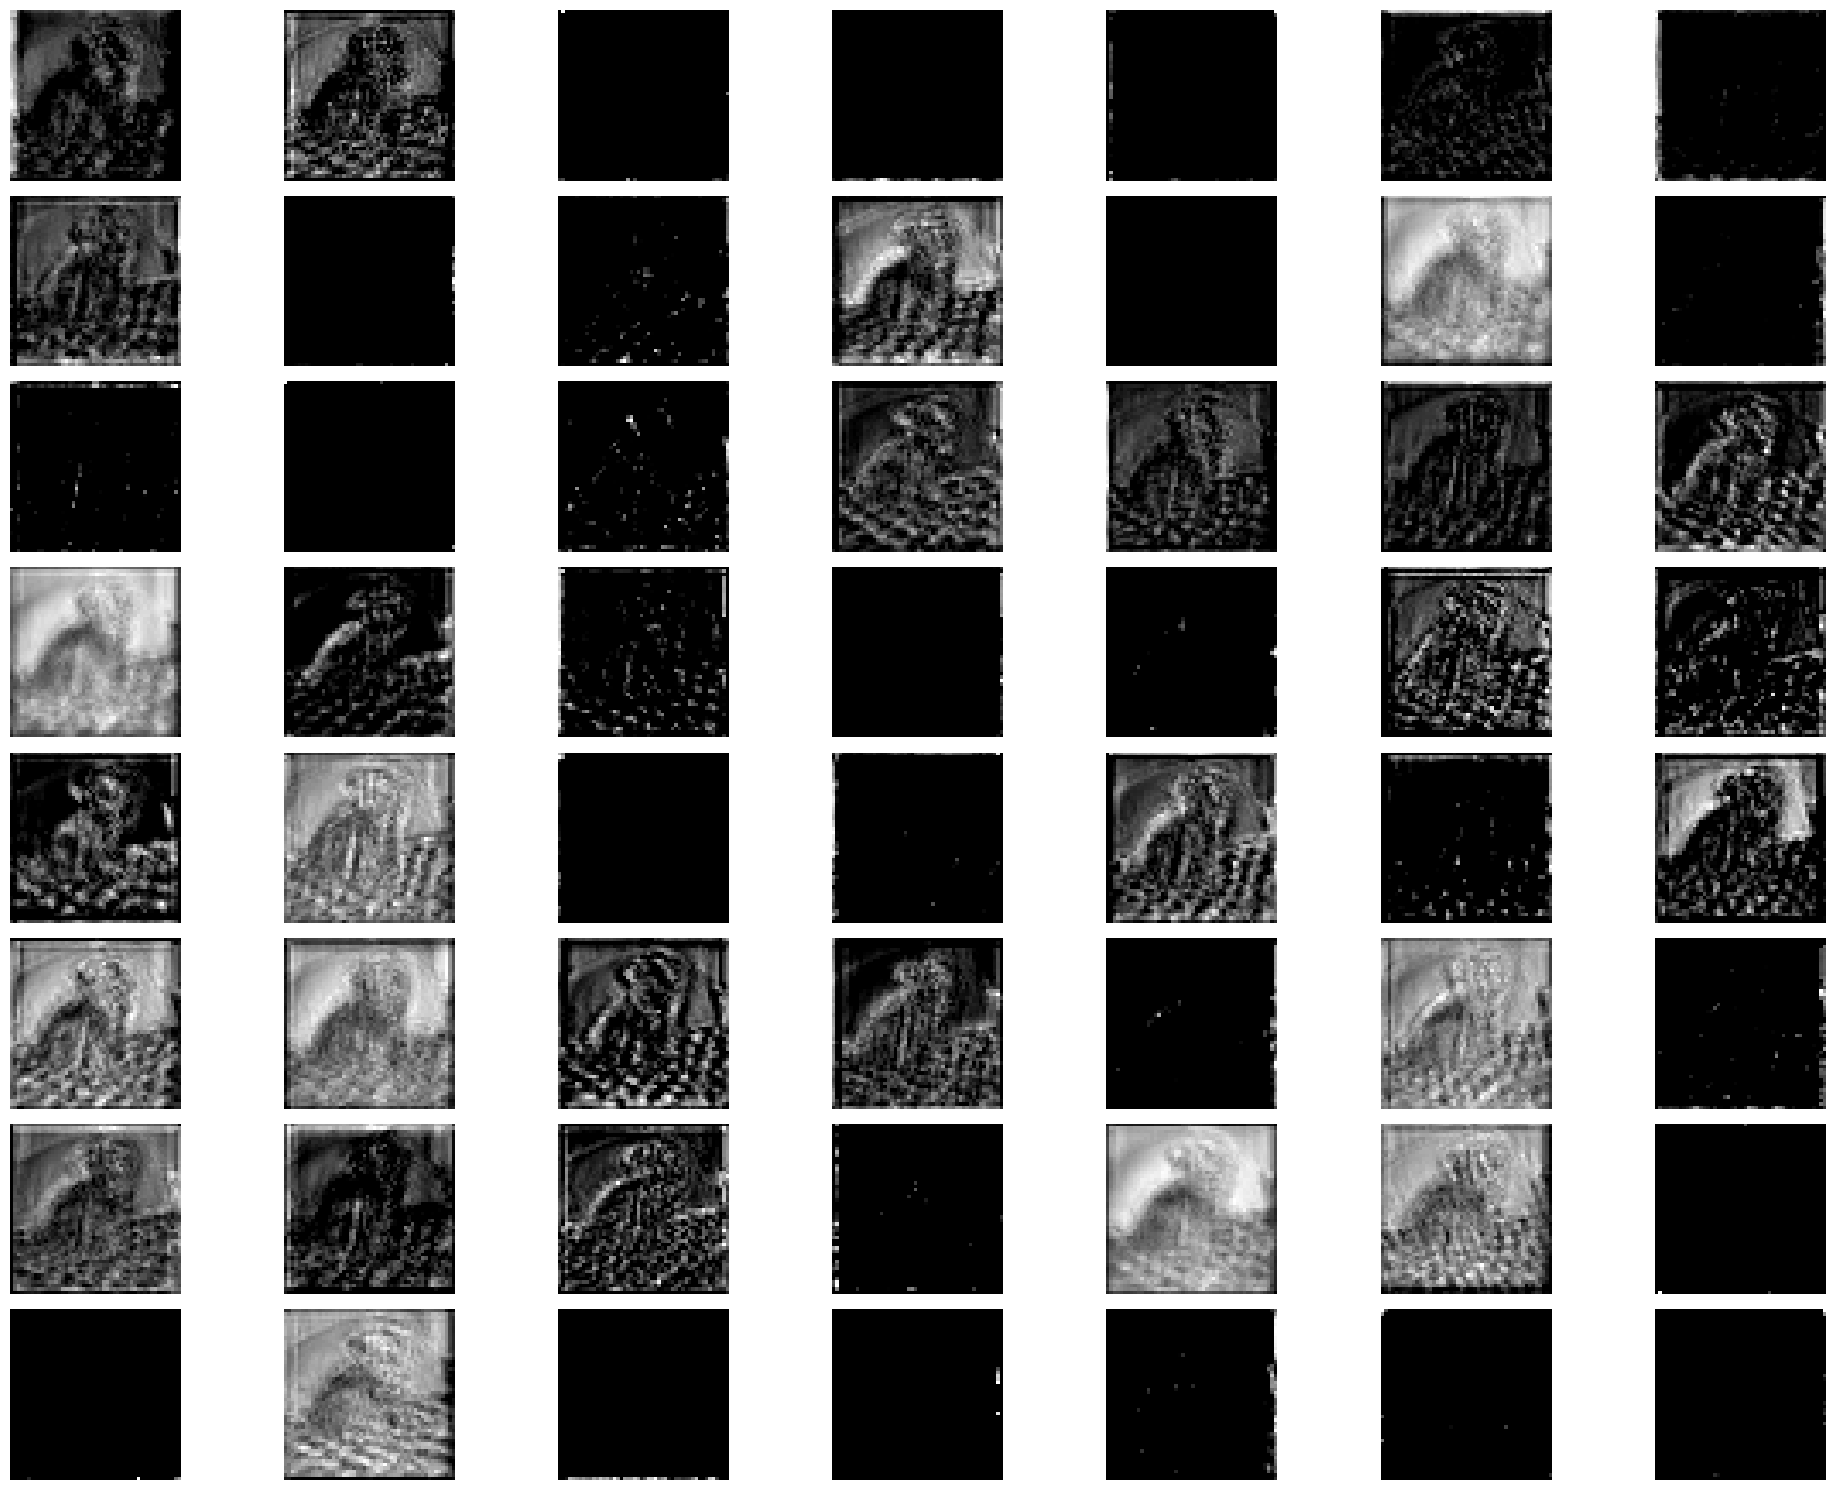

In [11]:
num_features = feature_map.shape[3]
max_features_to_display = min(num_features, 56)
fig = plt.figure(figsize=(20, 15))


for index in range(max_features_to_display):
    plt.subplot(8, 7, index + 1)
    plt.imshow(np.clip(feature_map[0, :, :, index], 0, 1), cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()

## 2. **Generate Region Proposals with RPN**
   - Define anchor boxes of various sizes and aspect ratios.
   - Use a CNN to predict objectness scores and refine anchor box coordinates.
   - Compute RPN loss (classification and regression).

### Define Anchor boxes of various sizes and aspect ratios
<ul>
    <li> Calculate Anchor Centers</li>
    <li> Create Anchor Box</li>
    <li> Create Anchor Box Of Different Aspect Ratios, Scales</li>
</ul>

In [12]:
def get_number_of_anchor_points(feature_map) -> (int, int, int):
    """
    Calculates the number of anchor points (centers) for the the feature_map

    Parameters
    ----------
    feature_map: Feature Map created by CNN backbone
    ----------

    Returns
    ----------
    Tuple[int, int, int]
        Tuple of the Number of anchor points, the X-axis size of the feature map, the Y-axis size of the feature map
    ----------
    """

    if len(feature_map.shape) != 4:
        raise ValueError("Input must be a 4D tensor with shape (batch_size, height, width, channels)")
    
    # Get the Shape of the Image (WxH)
    _, axis_1, axis_2, _ = feature_map.shape
    # Total Number of Anchor Points Possible is WxH
    anchors = axis_1 * axis_2
    # Return Tuple of Number of Anchors, Axis Sizes
    return anchors, axis_1, axis_2

In [13]:
number_of_anchors,x_axis,y_axis = get_number_of_anchor_points(feature_map)
print(f'Number Of Anchor Points (Centers) To Be Placed On Feature Map: {number_of_anchors}')

Number Of Anchor Points (Centers) To Be Placed On Feature Map: 2500


In [14]:
def calculate_anchor_stride(original_size, feature_map_size):
    """
    Calculates the stride based on the original size and feature map size.

    Parameters
    ----------
    original_size: int
        Size of the original image (width or height).
    feature_map_size: int
        Size of the feature map (width or height).

    Returns
    ----------
    int
        Stride value.
    """
    return original_size // feature_map_size

In [15]:
# Calculate the anchor centers using stride based on the size of the image and adjusting it to the feature map
anchor_stride_x , anchor_stride_y = calculate_anchor_stride(800,feature_map.shape[1]),calculate_anchor_stride(800,feature_map.shape[2])
print(f'Anchor X Stride: {anchor_stride_x}, Anchor Y Stride: {anchor_stride_y}')

Anchor X Stride: 16, Anchor Y Stride: 16


In [16]:
def create_anchor_centers(feature_map_width, feature_map_height, image_width=800, image_height=800):
    """
    Creates anchor centers for the feature map.

    Parameters
    ----------
    feature_map_width: int
        Width of the feature map.
    feature_map_height: int
        Height of the feature map.
    image_width: int
        Width of the original image (default is 800).
    image_height: int
        Height of the original image (default is 800).

    Returns
    ----------
    np.ndarray
        Array of anchor center coordinates.
    """
    # Calculate strides
    anchor_stride_x = calculate_anchor_stride(image_width, feature_map_width)
    anchor_stride_y = calculate_anchor_stride(image_height, feature_map_height)

    # Creating anchor centers based on the feature map size, 0.5 to center for each pixel
    anchors_x_center = (np.arange(feature_map_width) + 0.5)
    anchors_y_center = (np.arange(feature_map_height) + 0.5)

    # Create a grid of anchor center coordinates based on the feature map size
    anchor_centers = np.array(np.meshgrid(anchors_x_center, anchors_y_center, indexing='xy')).T.reshape(-1, 2)

    return anchor_centers

In [17]:
# Calculating the anchor centers for the x and y axes
anchor_centers = create_anchor_centers(feature_map.shape[1], feature_map.shape[2])

print(f'Anchor Centers:\n{anchor_centers}')
print(f'Number of Anchor Centers: {len(anchor_centers)}')
print(f'Anchor Centers Shape: {anchor_centers.shape}')

Anchor Centers:
[[ 0.5  0.5]
 [ 0.5  1.5]
 [ 0.5  2.5]
 ...
 [49.5 47.5]
 [49.5 48.5]
 [49.5 49.5]]
Number of Anchor Centers: 2500
Anchor Centers Shape: (2500, 2)


In [18]:
# REFERENCE: Calculating anchor center grid to be placed on the original image (800,800)
anchor_centers_image = create_anchor_centers(feature_map.shape[1], feature_map.shape[2]) * anchor_stride_x
print(f'Anchor Centers Preview (Image):\n {anchor_centers_image}')
print(f'Number of Anchor Centers: {len(anchor_centers_image)}')

Anchor Centers Preview (Image):
 [[  8.   8.]
 [  8.  24.]
 [  8.  40.]
 ...
 [792. 760.]
 [792. 776.]
 [792. 792.]]
Number of Anchor Centers: 2500


In [19]:
# UTILITY: Displaying Center Grid
def display_center_grid(img, anchor_center_coord, number_of_anchors) -> np.array:
    """
    Creates a grid of the anchor points for the image

    Parameters
    ----------
    img: Input Image
    anchor_center_coord: Array of anchor centers
    number_of_anchors: Number of anchors for the Image
    ----------

    Returns
    ----------
    img_copy
        Image copy that has the bounding box created over it
    ----------
    """

    # Copy of the input image to be manipulated
    img_copy = np.copy(img)

    # Iterate over the image and create the anchor coordinate grid
    for i in range(number_of_anchors):
        cv.circle(img_copy, (int(anchor_center_coord[i][0]), int(anchor_center_coord[i][1])), radius=2,
                  color=(255, 0, 0), thickness=1)

    # img_copy = cv.addWeighted(img_copy,0.4,img,1-0.4,0)

    # Image with Anchor Grid
    return img_copy

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


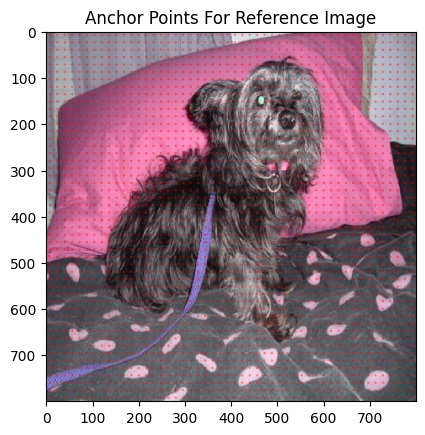

In [20]:
# Viewing Anchor Centers On Reference Image For Debugging
grid_image = display_center_grid(img_pre[0],anchor_centers_image,number_of_anchors)
plt.imshow(display_center_grid(img_pre[0],anchor_centers_image,number_of_anchors))
plt.title("Anchor Points For Reference Image")
plt.savefig("Reference Image Anchor Points")

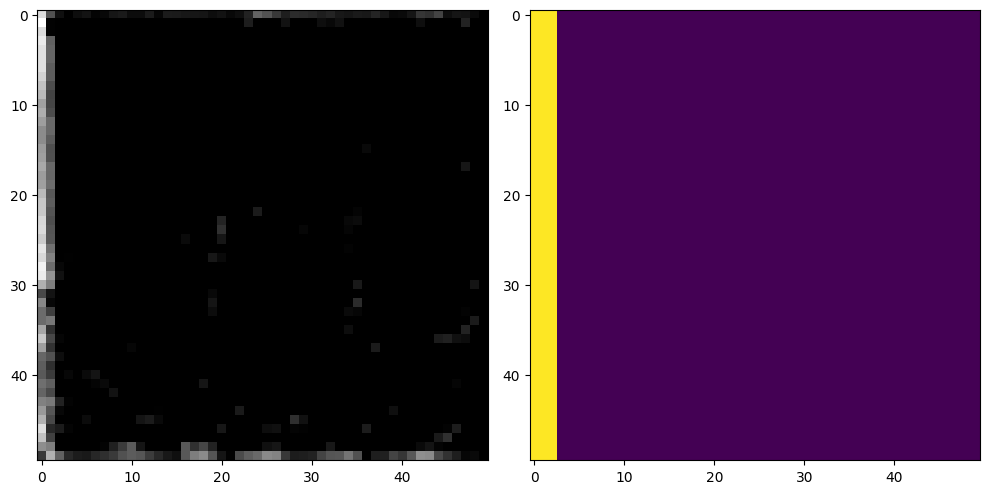

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(feature_map[0,:,:,6], cmap='gray')
ax[1].imshow(display_center_grid(feature_map[0,:,:,6],anchor_centers,50))
plt.tight_layout()
plt.show()

In [22]:
# UTILITY: Creating Anchor Boxes
def create_anchor_boxes(x1, y1, x2, y2, img) -> np.array:
    """
    Creates a grid of the anchor points for the image

    Parameters
    ----------
    x1: X-coordinate of Top Left Corner
    y1: Y-coordinate of Top Left Corner
    x2: X-coordinate of Bottom Right Corner
    y2: Y-coordinate of Bottom Right Corner
    colour: Color for the anchor boxes
    ----------

    Returns
    ----------
    img_box
        Image with anchor box
    ----------
    """
    # Creating Center Coordinate To Isolate Point For Better Understanding
    center_x = (x1+x2) // 2
    center_y = (y1+y2) // 2
    
    # Creating the bounding box centered over a pixel
    img_box = cv.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 3)
    img_box = cv.circle(img_box,(center_x,center_y),5,(0,255,0),-1)
    # Image with bounding box
    return img_box

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


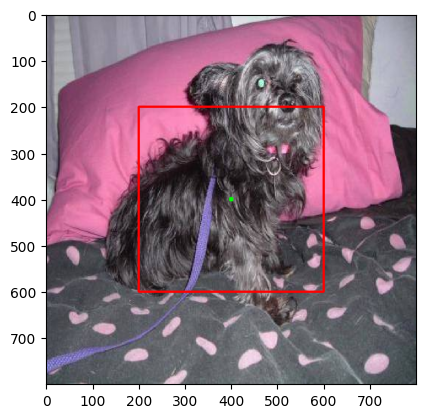

In [23]:
# Testing Anchor Box Creation
plt.imshow(create_anchor_boxes(200,200,600,600,img_pre[0]))

In [24]:
# Creating Different Aspect Anchor Boxes

BASE_ANCHOR_BOX_SIZE = [128,128]
ANCHOR_BOX_RATIOS=[0.5,1,1.5]
ANCHOR_BOX_SCALES = [1,2,3]

def create_aspect_boxes(anchor_box_ratios, anchor_box_scales, base_anchor_box):
    """
    Creates anchor boxes of different ratios and scales

    Parameters
    ----------
    anchor_box_ratio: Different aspect ratios used for the bounding boxes
    anchor_box_scales: Different scale ratios used for the bounding boxes
    base_anchor_box: Base anchor box size
    ----------

    Returns
    ----------
    aspect_box
        List of anchor boxes with different scales and aspect ratios for each anchor point
    ----------
    """

    aspect_box = []
    # Iterate Over the ratios and scales and transform the bounding box dimensions.
    for ratios in anchor_box_ratios:
        for scales in anchor_box_scales:
            scaled_box = [base_anchor_box[0] * scales, base_anchor_box[1] * scales]
            if ratios < 1:
                # Wider Box
                aspect_box.append([scaled_box[0], scaled_box[1] / ratios])
            else:
                # Taller Box
                aspect_box.append([scaled_box[0] * ratios, scaled_box[1]])
    return aspect_box

In [25]:
# Created Variable Aspect Ratio Boxes, Not The Absolute Coordinates But The Width & Height Of The Boxes
aspect_ratios_dimensions = create_aspect_boxes(ANCHOR_BOX_RATIOS,ANCHOR_BOX_SCALES,BASE_ANCHOR_BOX_SIZE)
print(f'Aspect Ratio Boxes Size: {aspect_ratios_dimensions}')
print(f'Number Of Aspect Ratio Anchor Boxes: {len(aspect_ratios_dimensions)}')

Aspect Ratio Boxes Size: [[128, 256.0], [256, 512.0], [384, 768.0], [128, 128], [256, 256], [384, 384], [192.0, 128], [384.0, 256], [576.0, 384]]
Number Of Aspect Ratio Anchor Boxes: 9


In [26]:
# Creating the Anchor Boxes Relative To The Center Of the Anchor Point
def relative_coordinates(aspect_boxes, x_c, y_c):
    """
    Creates a grid of the anchor points for the image

    Parameters
    ----------
    aspect_boxes: Array of bounding boxes with different aspect ratios and scales
    x_c: X center of the anchor
    y_c: Y center of the anchor
    ----------

    Returns
    ----------
    final_box
        List of anchor boxes for each anchor point
    ----------
    """
    final_box = []
    # Iterate over the transformed boxes and create coordinate relative to the center pixel.
    for boxes in aspect_boxes:
        width_alignment = boxes[0] / 2
        height_alignment = boxes[1] / 2
        final_box.append([x_c - width_alignment, y_c - height_alignment, x_c + width_alignment, y_c + height_alignment])
    # Array of bounding boxes relative to the pixel
    return final_box

In [27]:
# Center Anchor Boxes In The Image
center_anchor_boxes = relative_coordinates(aspect_ratios_dimensions,anchor_centers_image[1250][0],anchor_centers_image[1250][1])
print(f'Center Variable Anchor Boxes:\n {center_anchor_boxes}')
print(f'Number Of Anchor Boxes Per Anchor Center: {len(center_anchor_boxes)}')

Center Variable Anchor Boxes:
 [[344.0, -120.0, 472.0, 136.0], [280.0, -248.0, 536.0, 264.0], [216.0, -376.0, 600.0, 392.0], [344.0, -56.0, 472.0, 72.0], [280.0, -120.0, 536.0, 136.0], [216.0, -184.0, 600.0, 200.0], [312.0, -56.0, 504.0, 72.0], [216.0, -120.0, 600.0, 136.0], [120.0, -184.0, 696.0, 200.0]]
Number Of Anchor Boxes Per Anchor Center: 9


In [28]:
# Creating function to initialize the anchor boxes for the model
# TODO: Implement To Uniform Shape (B,FEATURE_MAP_WIDTH,FEATURE_MAP_HEIGHT,NUM_OF_ANCHORS_PER_PIXEL,4)
def initialize_all_anchor_boxes(original_img_shape, feature_map_shape):
    """
    Creates the anchor boxes for feature map that can be used by the model

    Parameters
    ----------
    original_img_shape: Shape of the original image
    feature_map_shape: Shape of the feature map, without the batch dimension
    ----------

    Returns
    ----------
    feature_map_anchor_box_coordinates
        Tensor of anchor boxes for the feature map (B,FEATURE_MAP_WIDTH,FEATURE_MAP_HEIGHT,NUM_OF_ANCHORS_PER_PIXEL,4)
    ----------
    """
    # Calculate the anchor center strides for the X & Y axes
    anchor_stride_x , anchor_stride_y = calculate_anchor_stride(original_img_shape[1], feature_map_shape[1]) , calculate_anchor_stride(original_img_shape[2], feature_map_shape[2])
    # Calculating the anchor centers for the x and y axes
    anchor_centers = create_anchor_centers(feature_map_shape[1], feature_map_shape[2])
    # Calculating the different aspect ratios and scales for the anchor boxes
    aspect_ratios = tf.constant(create_aspect_boxes(ANCHOR_BOX_RATIOS,ANCHOR_BOX_SCALES,BASE_ANCHOR_BOX_SIZE),dtype=tf.float32)
    # Scaling the anchor box ratios to the feature map size since they are in the original image space for now
    feature_map_aspect_ratios = tf.stack([aspect_ratios[:,0]/anchor_stride_x,aspect_ratios[:,1]/anchor_stride_y],axis=1)
    
    # Calculating the anchor boxes for each center
    # Calculating the X,Y offsets to be added to the center point
    offset_x,offset_y = tf.cast(feature_map_aspect_ratios[:,0]/2,dtype=tf.float32), tf.cast(feature_map_aspect_ratios[:,1]/2,tf.float32)

    # Calculate the values by adding the offsets to the centers separately
    x_centers,y_centers = anchor_centers[:,0] , anchor_centers[:,1]
    # Repeat the tensor so that it is reshaped for the total number of anchor boxes per pixel since the centers for each of the aspect ratio boxes are the same
    x_centers = tf.cast(tf.repeat(x_centers,repeats=tf.shape(feature_map_aspect_ratios)[0]),tf.float32)
    y_centers = tf.cast(tf.repeat(y_centers,repeats=tf.shape(feature_map_aspect_ratios)[0]),tf.float32)

    # Tile the tensor so that the offsets are tiled since the aspect ratios are iterated over
    offset_x,offset_y = tf.tile(offset_x,[tf.shape(anchor_centers)[0]]),tf.tile(offset_y,[tf.shape(anchor_centers)[0]])
    
    # Calculate the four coordinates for the anchor box using the centers
    x_1 = x_centers - offset_x
    x_2 = x_centers + offset_x
    y_1 = y_centers - offset_y
    y_2 = y_centers + offset_y

    # Clipping anchor boxes to stop the the coordinates from going out of bounds
    x_1 = tf.maximum(x_1,0)
    x_2 = tf.minimum(x_2,feature_map_shape[0])
    y_1 = tf.maximum(y_1,0)
    y_2 = tf.minimum(y_2,feature_map_shape[1])
    
    # Stack the coordinates together in format of (B,FEATURE_MAP_WIDTH,FEATURE_MAP_HEIGHT,4)
    feature_map_anchor_box_coordinates = tf.stack([x_1,y_1,x_2,y_2],axis=1)
    feature_map_anchor_box_coordinates = tf.reshape(feature_map_anchor_box_coordinates,[feature_map_shape[1],feature_map_shape[2],-1,4])
    # Adding a batch dimension so that it can be tiled
    feature_map_anchor_box_coordinates = tf.expand_dims(feature_map_anchor_box_coordinates,axis=0)
    # Tiling the vector on the batch dimension only, everything else is kept as it is.
    feature_map_anchor_box_coordinates = tf.tile(feature_map_anchor_box_coordinates,[feature_map_shape[0],1,1,1,1])
    
    
    return feature_map_anchor_box_coordinates

In [29]:
initialize_all_anchor_boxes((2,800,800), (2,50,50,512))

<tf.Tensor: shape=(2, 50, 50, 9, 4), dtype=float32, numpy=
array([[[[[ 0. ,  0. ,  2. ,  8.5],
          [ 0. ,  0. ,  2. , 16.5],
          [ 0. ,  0. ,  2. , 24.5],
          ...,
          [ 0. ,  0. ,  2. ,  4.5],
          [ 0. ,  0. ,  2. ,  8.5],
          [ 0. ,  0. ,  2. , 12.5]],

         [[ 0. ,  0. ,  2. ,  9.5],
          [ 0. ,  0. ,  2. , 17.5],
          [ 0. ,  0. ,  2. , 25.5],
          ...,
          [ 0. ,  0. ,  2. ,  5.5],
          [ 0. ,  0. ,  2. ,  9.5],
          [ 0. ,  0. ,  2. , 13.5]],

         [[ 0. ,  0. ,  2. , 10.5],
          [ 0. ,  0. ,  2. , 18.5],
          [ 0. ,  0. ,  2. , 26.5],
          ...,
          [ 0. ,  0. ,  2. ,  6.5],
          [ 0. ,  0. ,  2. , 10.5],
          [ 0. ,  0. ,  2. , 14.5]],

         ...,

         [[ 0. , 39.5,  2. , 50. ],
          [ 0. , 31.5,  2. , 50. ],
          [ 0. , 23.5,  2. , 50. ],
          ...,
          [ 0. , 43.5,  2. , 50. ],
          [ 0. , 39.5,  2. , 50. ],
          [ 0. , 35.5,  2. , 50.

In [30]:
# UTILITY: DISPLAY VARIABLE ANCHOR BOXES
def create_relative_anchor_boxes(anchor_boxes, img):
    """
    Creates a grid of the anchor points for the image

    Parameters
    ----------
    image_tensor: Tensor with the image Anchor box
    img: Input Image
    colour: Color of the bounding box
    ----------

    Returns
    ----------
    None
    ----------
    """
    """
    
    """
    for coordinates in anchor_boxes:
            x1 = int(coordinates[0])
            y1 = int(coordinates[1])
            x2 = int(coordinates[2])
            y2 = int(coordinates[3])
            img = create_anchor_boxes(x1, y1, x2, y2, img)
        # Image with multiple bounding boxes over a central pixel
    return img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


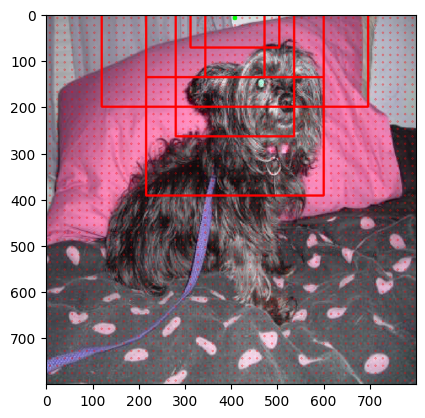

In [31]:
# Displaying Variable Anchor Box On Reference Image
plt.imshow(create_relative_anchor_boxes(center_anchor_boxes,grid_image))

### Use a CNN to predict objectness scores and refine anchor box coordinates.
<ul>
    <li> Predicting Objectness Scores</li>
    <li> Refine Anchor Box Coordinates</li>
</ul>

In [32]:
# Before Finding Objectness Score 3x3 sliding window (according to the paper) needs to be carried out over the feature map.
# This is part of the region proposal network (RPN)
# MODEL: Region Proposal Network Model To Be Used For Modularity In Faster RCNN Model

class RegionProposalNetwork(tf.keras.Model):
    def __init__(self,num_of_anchors_per_pixel,**kwargs):
        """
        Region Proposal Network (RPN) as a subclass of Keras Model.
        
        Parameters:
        ----------
        num_of_anchors_per_pixel : int
            Number of anchor boxes per pixel (depends on the scales and aspect ratios used).
        """
        super(RegionProposalNetwork,self).__init__(**kwargs)

        # Initializing Info About Input Size & Number Of Anchors
        self.num_of_anchors_per_pixel = num_of_anchors_per_pixel
        self.feature_map_height = 50
        self.feature_map_width = 50

        # Creating the convolutional 3x3 layer of the architecture
        self.conv_layer = Conv2D(512,(3,3),padding='same',activation='relu',name="3x3 Conv Layer")

        # Creating Binary Classification Layer To Predict Objects/Background
        self.object_classfication_layer = Conv2D(num_of_anchors_per_pixel * 2,(1,1),activation='softmax',name="Objectness Layer")

        # Creating Bounding Box Regression Layer To Calculate Offsets For Anchor Boxes
        self.bounding_box_regression_layer = Conv2D(num_of_anchors_per_pixel * 4, (1,1),name="Bounding Box Regression Layer")

    def call(self,input_tensor):
        """
        Forward Pass For The Model Using Tensor Flow Model API

        Parameters:
        ---------
        input_tensor : Tensor
            Feature Maps Of Images

        Returns:
        -------
        object_scores: Tensor
            Predicted Scores Of Anchor Boxes Of Either Being Object/Background Made By Model

        offsets: Tensor
            Coordinates For Bounding Boxes Made By Model
        """

        # Need To Pass It Through The 3x3 Conv Layer
        conv_tensor = self.conv_layer(input_tensor)

        # Calculating The Objectness Score & Offset Regression Separately
        object_scores = self.object_classfication_layer(conv_tensor)
        offsets = self.bounding_box_regression_layer(conv_tensor)

        # reshaping the tensors to make into easier format
        object_scores = tf.reshape(object_scores,[object_scores.shape[0],object_scores.shape[1],object_scores.shape[2],self.num_of_anchors_per_pixel,2])
        offsets = tf.reshape(offsets,[offsets.shape[0],offsets.shape[1],offsets.shape[2],self.num_of_anchors_per_pixel,4])

        # We return the scores to the next part
        return object_scores, offsets

    def build_graph(self,input_size):
        """
        Build Graph Method For Examining Layer Architecture

        Parameters:
        ---------
        input_size : Tensor
            Feature Maps Of Images

        Returns:
        -------
           model: Tensorflow Model
               Tensorflow Model Of Region Proposal Network
        """
        x = tf.keras.layers.Input(shape=input_size)

        # Need To Pass It Through The 3x3 Conv Layer
        conv_tensor = self.conv_layer(x)

        # Calculating The Objectness Score & Offset Regression Separately
        object_scores = self.object_classfication_layer(conv_tensor)
        offsets = self.bounding_box_regression_layer(conv_tensor)

        # reshaping the tensors to make into easier format
        object_scores = tf.keras.layers.Reshape((self.feature_map_height, self.feature_map_width, self.num_of_anchors_per_pixel, 2),name="Objectness Score Reshape")(object_scores)
        offsets = tf.keras.layers.Reshape((self.feature_map_height, self.feature_map_width, self.num_of_anchors_per_pixel, 4),name="Bounding Box Offsets Reshape")(offsets)

        return tf.keras.Model(inputs=[x],outputs=[object_scores,offsets])
        

In [33]:
region_proposal_network = RegionProposalNetwork(num_of_anchors_per_pixel=9)

In [34]:
region_proposal_network.build_graph(input_size=(50,50,512)).summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 50, 50,    │          0 │ -                 │
│ (InputLayer)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ 3x3 Conv Layer      │ (None, 50, 50,    │  2,359,808 │ input_layer_1[0]… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Objectness Layer    │ (None, 50, 50,    │      9,234 │ 3x3 Conv          │
│ (Conv2D)            │ 18)               │            │ Layer[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Bounding Box        │ (None, 50, 50,    │     18,468 │ 3x3 Conv          │
│ Regression Layer    │ 36)               │            │ Layer[0][0]       │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Objectness Score    │ (None, 50, 50, 9, │          0 │ Objectness        │
│ Reshape (Reshape)   │ 2)                │            │ Layer[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Bounding Box        │ (None, 50, 50, 9, │          0 │ Bounding Box      │
│ Offsets Reshape     │ 4)                │            │ Regression        │
│ (Reshape)           │                   │            │ Layer[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,387,510 (9.11 MB)

 Trainable params: 2,387,510 (9.11 MB)

 Non-trainable params: 0 (0.00 B)

<p align="center">
    <img src="image_coordinate_axes.png" height="600" width="600">
</p>

In [35]:
# Intersection Over Union Implementation
# Each Ground Truth Box is compared to all the predicted anchor boxes and 
# Now this function calculates the IOU Scores of one ground truth box with all the anchor boxes
# TODO: Implement To Uniform Shape (B,FEATURE_MAP_WIDTH,FEATURE_MAP_HEIGHT,NUM_OF_ANCHORS_PER_PIXEL,1)
def IOU_scores(ground_truth_boxes,predicted_boxes):
    """
    Calculate IOU Scores For Ground Truth Boxes & All Prediction Boxes

    Parameters:
    ---------
    ground_truth_boxes : Tensor
        Tensor Of Ground Truth Boxes (B,NO_OF_GT_BOXES,4)

    predicted_boxes : Tensor
        Tensor Of Prediction Boxes (B,FEATURE_MAP_WIDTH * FEATURE_MAP_HEIGHT * NUM_OF_ANCHORS_PER_PIXEL,4)    

    Returns:
    -------
    iou_scores: Tensor
        Tensor Of IOU Scores (B,NO_OF_GT_BOXES,NO_OF_PRED_BOXES)
        NOTE: Each row is a ground truth box and each column is a anchor prediction box
    """
    
    # First we need to split up the two boxes into four coordinates each
    x11,y11,x21,y21 = tf.split(ground_truth_boxes,num_or_size_splits=4,axis=-1)
    x12,y12,x22,y22 = tf.split(predicted_boxes,num_or_size_splits=4,axis=-1)

    # print(f'Coordinates Of Box 1: x1:{x11},y1:{y11},x2:{x21},y2:{y21}')
    # print(f'Coordinates Of Box 2: x1:{x12},y1:{y12},x2:{x22},y2:{y22}')

    x1_max = tf.expand_dims(x11,axis=2)
    y1_max = tf.expand_dims(y11,axis=2)

    x2_min = tf.expand_dims(x21,axis=2)
    y2_min = tf.expand_dims(y21,axis=2)

    # Now we to get the max and min values for each axes for each top left and bottom right corner of the box
    x1_max = tf.math.maximum(x1_max,x12)
    y1_max = tf.math.maximum(y1_max,y12)

    x2_min = tf.math.minimum(x2_min,x22)
    y2_min = tf.math.minimum(y2_min,y22)

    # print(f'X1 Max: {x1_max[0]}')
    # print(f'Y1 Max: {y1_max[0]}')
    
    # print(f'X2 Min: {x2_min}')
    # print(f'Y2 Min: {y2_min}')

    # print(f'Top Left Intersection Coordinates {tf.concat([x1_max[0],y1_max[0]],axis=1)}')
    # print(f'Bottom Right Intersection Coordinates {tf.concat([x2_min[0],y2_min[0]],axis=1)}')


    # Now we need to calculate the width and height of the intersection box, we need to stop it from being non-negative as well
    width = tf.math.maximum(0.0,x2_min - x1_max)
    height = tf.math.maximum(0.0,y2_min - y1_max)

    # print(f'Width Of Intersection: {width}')
    # print(f'Height Of Intersection: {height}')

    # Calculate the area of the intersection box for IOU scores
    area_of_intersection = width * height

    # Calculate area of ground truth boxes
    ground_truth_boxes_area = (x21-x11) * (y21-y11)
    ground_truth_boxes_area = tf.expand_dims(ground_truth_boxes_area,axis=2)

    # Calculate are of predicted boxes
    predicted_boxes_area = (x22 - x12) * (y22-y12)
    
    # Calculate the are of the union of the two boxes using venn diagram formula
    area_of_union = tf.maximum(0.0,ground_truth_boxes_area + predicted_boxes_area - area_of_intersection)

    # Calculate IOU score using the formula
    iou_scores = area_of_intersection / area_of_union

    # print(f'Area of GT Boxes : {ground_truth_boxes_area}')
    # print(f'Area of Pred Boxes: {predicted_boxes_area}')
    # print(f'Area of Intersection: {area_of_intersection}')
    # print(f'Area of Union: {area_of_union}')
    # print(f'IOU Scores: {(iou_scores}')
    
    return tf.squeeze(iou_scores, axis=-1)

    

In [36]:
# Ground Truth Boxes (top-left (x1, y1), bottom-right (x2, y2))
ground_truth_boxes = tf.constant([
    [1, 2, 3, 4],   # Box 1
    [2, 3, 4, 5],   # Box 2
    [4, 1, 5, 4]    # Box 3
], dtype=tf.float32)
# Predicted Boxes (top-left (x1, y1), bottom-right (x2, y2))
predicted_boxes = tf.constant([
    [1, 1, 3, 3],
    [0, 0, 6, 6],  
    [4, 2, 5, 5],  
    [1, 2, 3, 4],
    [4, 1, 5, 4] 
], dtype=tf.float32)

# Creating Tensor of Shape (B,NO_OF_GT_BOXES,BOX_COORDINATES)
ground_truth_boxes = tf.expand_dims(ground_truth_boxes,axis=0)
# Creating Tensor of Shape (B,NO_OF_PRED_BOXES,BOX_COORDINATES)
predicted_boxes = tf.expand_dims(predicted_boxes,axis=0)

iou_scores = IOU_scores(ground_truth_boxes,predicted_boxes)
iou_scores # Row is a ground truth box, column is the anchor box

<tf.Tensor: shape=(1, 3, 5), dtype=float32, numpy=
array([[[0.33333334, 0.11111111, 0.        , 1.        , 0.        ],
        [0.        , 0.11111111, 0.        , 0.14285715, 0.        ],
        [0.        , 0.08333334, 0.5       , 0.        , 1.        ]]],
      dtype=float32)>

In [37]:
# UTILITY: Utility Function To Check IOU intersection
def plot_bounding_boxes(ground_truth_boxes, predicted_boxes):
    # Iterating over the batches
    for batch in range(ground_truth_boxes.shape[0]):

        # Split ground truth boxes into four coordinates
        gt_x1,gt_y1,gt_x2,gt_y2 = tf.split(ground_truth_boxes[batch,:,:],num_or_size_splits=4,axis=-1)
    
        # Split predicted boxes into four coordinates
        pred_x1,pred_y1,pred_x2,pred_y2 = tf.split(predicted_boxes[batch,:,:],num_or_size_splits=4,axis=-1)

        iou_scores = IOU_scores(ground_truth_boxes,predicted_boxes)[batch,:,:]

        # Configure the subplots
        fig,axs = plt.subplots(ground_truth_boxes.shape[1],figsize=(8, 8 * ground_truth_boxes.shape[1]))

        # Iterate over ground truth boxes and create separate plots
        for box_index in range(0,ground_truth_boxes.shape[1]):
            gt_bottom_left_x = gt_x1[box_index].numpy()
            gt_bottom_left_y = gt_y2[box_index].numpy()  # bottom-left is at y2 (lower)
            gt_width = gt_x2[box_index].numpy() - gt_x1[box_index].numpy()
            gt_height = gt_y1[box_index].numpy() - gt_y2[box_index].numpy()
        
            axs[box_index].add_patch(plt.Rectangle(
                (gt_bottom_left_x, gt_bottom_left_y),  # Bottom left corner
                gt_width,  # Width
                gt_height,  # Height
                edgecolor='green',
                facecolor='none',
                linewidth=2,
                label='Ground Truth'
            ))

            # Set plot limits and titles
            axs[box_index].set_xlim(0, 8)  # Adjust based on your coordinate limits
            axs[box_index].set_ylim(0, 8)  # Adjust based on your coordinate limits
            axs[box_index].set_title(f'Ground Truth Box {box_index + 1}')
            axs[box_index].set_xlabel('X-axis')
            axs[box_index].set_ylabel('Y-axis')
            axs[box_index].set_aspect('equal', adjustable='box')  # Equal aspect ratio

            for pred_index in range(0,predicted_boxes.shape[1]):
                pred_bottom_left_x = pred_x1[pred_index].numpy()
                pred_bottom_left_y = pred_y2[pred_index].numpy()  # bottom-left is at y2 (lower)
                pred_width = pred_x2[pred_index].numpy() - pred_x1[pred_index].numpy()
                pred_height = pred_y1[pred_index].numpy() - pred_y2[pred_index].numpy()
            
                axs[box_index].add_patch(plt.Rectangle(
                    (pred_bottom_left_x, pred_bottom_left_y),  # Bottom left corner
                    pred_width,  # Width
                    pred_height,  # Height
                    edgecolor='orange',
                    facecolor='none',
                    linewidth=1,
                    linestyle='--',
                    label='Predicted'
                ))

                axs[box_index].text(pred_x1[pred_index].numpy(),pred_y1[pred_index].numpy(),f'IOU: {iou_scores[box_index,pred_index]:.2f}',verticalalignment='bottom')
        
            axs[box_index].legend(['Ground Truth', 'Predicted'], loc='upper right')

        # Add overall legend for the entire figure
        plt.legend(['Ground Truth', 'Predicted'], loc='upper right')
        plt.tight_layout()
        plt.show()

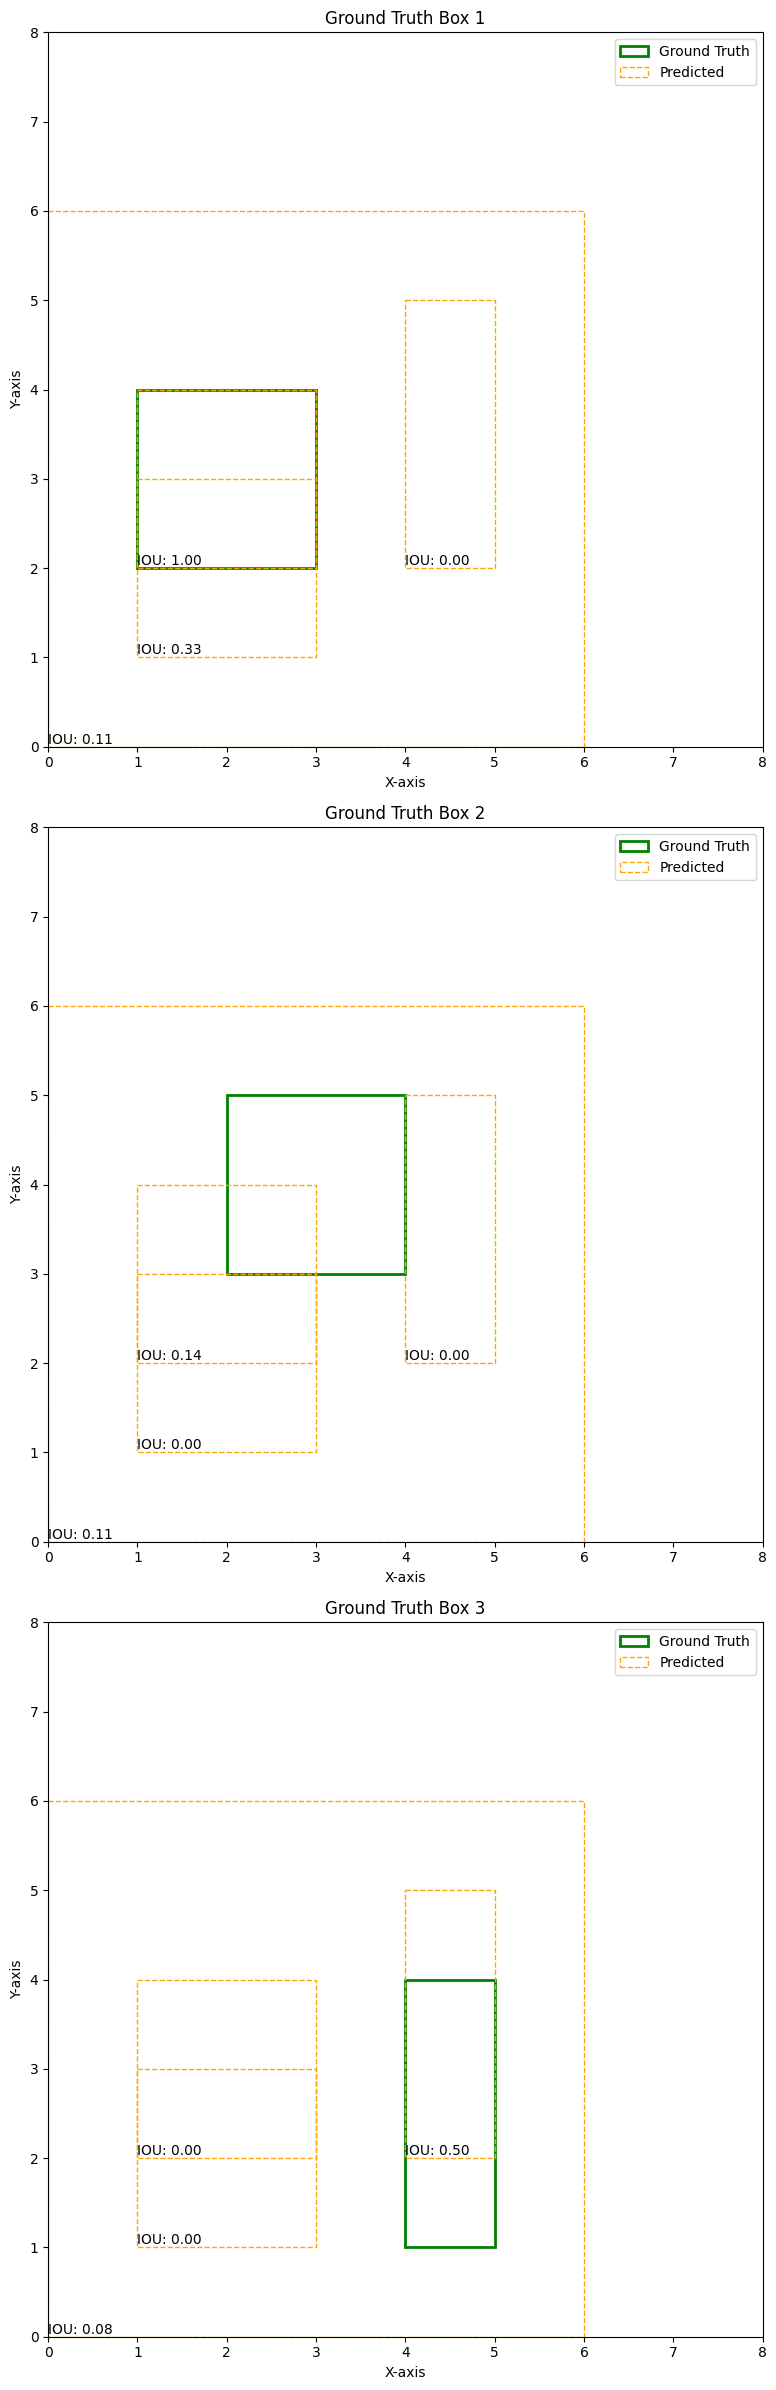

In [38]:
# Ground Truth Boxes (top-left (x1, y1), bottom-right (x2, y2))
ground_truth_boxes = tf.constant([
    [1, 2, 3, 4],   # Box 1
    [2, 3, 4, 5],   # Box 2
    [4, 1, 5, 4]    # Box 3
], dtype=tf.float32)
# Predicted Boxes (top-left (x1, y1), bottom-right (x2, y2))
predicted_boxes = tf.constant([
    [1, 1, 3, 3],  # Box 1
    [0, 0, 6, 6],  # Box 2
    [4, 2, 5, 5],  # Box 3
    [1, 2, 3, 4]
], dtype=tf.float32)

# Creating Tensor of Shape (B,NO_OF_GT_BOXES,BOX_COORDINATES)
ground_truth_boxes = tf.expand_dims(ground_truth_boxes,axis=0)
# Creating Tensor of Shape (B,NO_OF_PRED_BOXES,BOX_COORDINATES)
predicted_boxes = tf.expand_dims(predicted_boxes,axis=0)

plot_bounding_boxes(ground_truth_boxes,predicted_boxes)

In [39]:
# Checking if the initialized anchor boxes can be used in the IOU scoring function
anchor_boxes = initialize_all_anchor_boxes((1,800,800), (1,50,50,512))
print(anchor_boxes)

tf.Tensor(
[[[[[ 0.   0.   1.   8.5]
    [ 0.   0.   1.  16.5]
    [ 0.   0.   1.  24.5]
    ...
    [ 0.   0.   1.   4.5]
    [ 0.   0.   1.   8.5]
    [ 0.   0.   1.  12.5]]

   [[ 0.   0.   1.   9.5]
    [ 0.   0.   1.  17.5]
    [ 0.   0.   1.  25.5]
    ...
    [ 0.   0.   1.   5.5]
    [ 0.   0.   1.   9.5]
    [ 0.   0.   1.  13.5]]

   [[ 0.   0.   1.  10.5]
    [ 0.   0.   1.  18.5]
    [ 0.   0.   1.  26.5]
    ...
    [ 0.   0.   1.   6.5]
    [ 0.   0.   1.  10.5]
    [ 0.   0.   1.  14.5]]

   ...

   [[ 0.  39.5  1.  50. ]
    [ 0.  31.5  1.  50. ]
    [ 0.  23.5  1.  50. ]
    ...
    [ 0.  43.5  1.  50. ]
    [ 0.  39.5  1.  50. ]
    [ 0.  35.5  1.  50. ]]

   [[ 0.  40.5  1.  50. ]
    [ 0.  32.5  1.  50. ]
    [ 0.  24.5  1.  50. ]
    ...
    [ 0.  44.5  1.  50. ]
    [ 0.  40.5  1.  50. ]
    [ 0.  36.5  1.  50. ]]

   [[ 0.  41.5  1.  50. ]
    [ 0.  33.5  1.  50. ]
    [ 0.  25.5  1.  50. ]
    ...
    [ 0.  45.5  1.  50. ]
    [ 0.  41.5  1.  50. ]
    [ 0.  37.

In [40]:
# The model predicts offsets so the anchor boxes need to be converted from (x1,y1,x2,y2) format to (xc,yc,w,h) for refinement
# Creating a function to convert the formats of the anchor boxes
def convert_bounding_box_format(anchor_boxes):
    """
    Calculate the anchor box format from (x1,y1,x2,y2) to (xc,yc,w,h) so that the refinements can be calculated

    Parameters:
    ---------
    anchor_boxes : Tensor
        Tensor Of Ground Truth Boxes (B,FEATURE_MAP_WIDTH,FEATURE_MAP_HEIGHT,NUM_OF_ANCHORS_PER_PIXEL,4)

    Returns:
    -------
    converted_boxes: Tensor
        Tensor Of Anchor boxes (B,FEATURE_MAP_WIDTH,FEATURE_MAP_HEIGHT,NUM_OF_ANCHORS_PER_PIXEL,4)
        NOTE: Used for anchor box offset refinements only
    """
    # Split the coordinates into their individual points for both the axes
    x1,y1,x2,y2 = tf.split(anchor_boxes,num_or_size_splits=4,axis=-1)

    # There is an issue where splitting creates a new dimension in the tensor making the shape 
    # from (B,FEATURE_MAP_WIDTH,FEATURE_MAP_HEIGHT,NUM_OF_ANCHORS) to (B,FEATURE_MAP_WIDTH,FEATURE_MAP_HEIGHT,NUM_OF_ANCHORS,1)
    x1 = tf.squeeze(x1,axis=-1)
    x2 = tf.squeeze(x2,axis=-1)
    y1 = tf.squeeze(y1,axis=-1)
    y2 = tf.squeeze(y2,axis=-1)

    # Calculating the centers and the width and height of the boxes
    xc = (x2-x1) / 2.0
    yc = (y2-y1) / 2.0
    w = (x2 - x1)
    h = (y2 - y1)

    # Stacking the boxes after squeezing makes the shape to be (B,FEATURE_MAP_WIDTH,FEATURE_MAP_HEIGHT,NUM_OF_ANCHORS,4)
    # instead of (B,FEATURE_MAP_WIDTH,FEATURE_MAP_HEIGHT,NUM_OF_ANCHORS,1,4)
    converted_boxes = tf.stack([xc,yc,w,h],axis=-1)

    return converted_boxes
    

In [41]:
convert_bounding_box_format(anchor_boxes)

<tf.Tensor: shape=(1, 50, 50, 9, 4), dtype=float32, numpy=
array([[[[[  0.5 ,   4.25,   1.  ,   8.5 ],
          [  0.5 ,   8.25,   1.  ,  16.5 ],
          [  0.5 ,  12.25,   1.  ,  24.5 ],
          ...,
          [  0.5 ,   2.25,   1.  ,   4.5 ],
          [  0.5 ,   4.25,   1.  ,   8.5 ],
          [  0.5 ,   6.25,   1.  ,  12.5 ]],

         [[  0.5 ,   4.75,   1.  ,   9.5 ],
          [  0.5 ,   8.75,   1.  ,  17.5 ],
          [  0.5 ,  12.75,   1.  ,  25.5 ],
          ...,
          [  0.5 ,   2.75,   1.  ,   5.5 ],
          [  0.5 ,   4.75,   1.  ,   9.5 ],
          [  0.5 ,   6.75,   1.  ,  13.5 ]],

         [[  0.5 ,   5.25,   1.  ,  10.5 ],
          [  0.5 ,   9.25,   1.  ,  18.5 ],
          [  0.5 ,  13.25,   1.  ,  26.5 ],
          ...,
          [  0.5 ,   3.25,   1.  ,   6.5 ],
          [  0.5 ,   5.25,   1.  ,  10.5 ],
          [  0.5 ,   7.25,   1.  ,  14.5 ]],

         ...,

         [[  0.5 ,   5.25,   1.  ,  10.5 ],
          [  0.5 ,   9.25,   1.  ,  18.

In [42]:
# Calculating the bounding box deltas for the predicted boxes and the actual boxes
def calculate_bounding_box_deltas(gt_boxes,anchor_boxes):

    # Splitting the ground truth boxes into xc,yc,w,h separately
    gt_xc,gt_yc,gt_w,gt_h = tf.split(gt_boxes,num_or_size_splits = 4,axis=-1)

    # Splitting the predicted boxes into xc,yc,w,h separately
    pred_xc,pred_yc,pred_w,pred_h = tf.split(anchor_boxes,num_or_size_splits = 4,axis=-1)

    # Each offset is the difference (gt_xc-pred_xc)/pred_w according to the paper
    tx = (gt_xc - pred_xc) / pred_w
    ty = (gt_yc - pred_yc) / pred_h

In [43]:
# IOU Thresholds For Determining If Object Is Positive (Foreground) or Negative (Background)
IOU_FOREGROUND_THRESH = 0.7 # Used In The Paper
IOU_BACKGROUND_THRESH = 0.4

In [44]:
# Assigning Positive Or Negative Labels
# For Each Ground Truth Box & Predicted Box Combo Assign A Label
def assign_object_label(iou_scores_tensor,IOU_FOREGROUND_THRESH = 0.7,IOU_BACKGROUND_THRESH = 0.4,FEATURE_MAP_WIDTH= 50,FEATURE_MAP_HEIGHT= 50,NUM_OF_ANCHORS_PER_PIXEL= 9):
    """
    Assign Object Labels If They Are Foreground (Object) or Background

    Parameters:
    ---------
    iou_scores_tensor : Tensor
        Tensor Of IOU Scores Shape (B,GT_BOXES,PRED_BOXES)

    Returns:
    -------
    object_label_tensor: Tensor
        Tensor Of Object Labels (B,GT_BOXES,PRED_BOXES)
    """
    
    # Need to implement the rule where max IOU per anchor box is considered
    max_iou_per_anchor_box = tf.reduce_max(iou_scores_tensor,axis=1)
    
    # Everything is considered a background. So it does not need to check for negative labels.
    object_label_tensor = tf.zeros_like(max_iou_per_anchor_box,dtype=tf.int32)

    # Calculate Positive Labels -> Ignored Labels
    object_label_tensor = tf.where(max_iou_per_anchor_box >IOU_FOREGROUND_THRESH,1,object_label_tensor)
    object_label_tensor = tf.where((max_iou_per_anchor_box <= IOU_FOREGROUND_THRESH) & (max_iou_per_anchor_box >= IOU_BACKGROUND_THRESH),-1,object_label_tensor)

    # Reshaping the objectness labels to the shape (B,FEATURE_MAP_WIDTH,FEATURE_MAP_HEIGHT,NUM_OF_ANCHORS_PER_PIXEL,1)
    object_label_tensor = tf.reshape(object_label_tensor,(iou_scores.shape[0],FEATURE_MAP_WIDTH,FEATURE_MAP_HEIGHT,NUM_OF_ANCHORS_PER_PIXEL,1))

    return object_label_tensor

In [45]:
# Calculating the object labels for the batches
# assign_object_label(iou_scores)

In [46]:
iou_scores

<tf.Tensor: shape=(1, 3, 5), dtype=float32, numpy=
array([[[0.33333334, 0.11111111, 0.        , 1.        , 0.        ],
        [0.        , 0.11111111, 0.        , 0.14285715, 0.        ],
        [0.        , 0.08333334, 0.5       , 0.        , 1.        ]]],
      dtype=float32)>

In [47]:
objectness_score,offsets = region_proposal_network.call(feature_map)

In [48]:
feature_map.shape

TensorShape([1, 50, 50, 512])

In [49]:
objectness_score.shape

TensorShape([1, 50, 50, 9, 2])

In [50]:
offsets

<tf.Tensor: shape=(1, 50, 50, 9, 4), dtype=float32, numpy=
array([[[[[-5.13626030e-04,  6.85637497e-05,  1.73695604e-04,
            5.03784628e-04],
          [-1.79735958e-04,  1.16923195e-03, -9.20662424e-04,
           -9.21116152e-05],
          [-1.05549372e-03,  3.18193837e-04, -1.31601118e-05,
           -9.74921859e-05],
          ...,
          [ 5.42352849e-04, -4.97703848e-04,  5.61415160e-04,
            6.99176919e-04],
          [ 1.00505864e-03, -3.56475532e-04, -2.60069442e-04,
           -1.82628617e-04],
          [-8.08229161e-05,  1.05022729e-04, -9.68101085e-06,
            4.82031872e-04]],

         [[-1.10527524e-03,  1.13903923e-04,  3.29946663e-04,
            9.71972186e-04],
          [ 7.51856714e-04,  2.04389653e-04, -1.66219764e-03,
            2.70554679e-04],
          [-7.49278523e-04,  5.11088525e-04, -4.15465503e-04,
            5.56088984e-04],
          ...,
          [ 9.09920142e-04, -4.85564378e-04,  1.22384564e-03,
            4.90490871e-04],

In [51]:
# Function that will generate the objectness labels (0-background,1-foreground,-1-Ignore) for the anchor boxes on the feature map
def generate_objectness_labels(anchor_boxes,gt_boxes):
    """
    Generate objectness labels for the anchor boxes in the feature map
     0 - Background
     1 - Object/Foreground
    -1 - Ignore Object

    Parameters:
    ---------
    anchor_boxes : Tensor
        Tensor of anchor boxes for the feature map (B,FEATURE_MAP_WIDTH,FEATURE_MAP_HEIGHT,NUM_OF_ANCHORS_PER_PIXEL,4)
    
    gt_boxes : Tensor
        Tensor Of Ground Truth Boxes (B,NO_OF_GT_BOXES,4)

    Returns:
    -------
    object_labels : Tensor
        Tensor of object labels based on the IOU Thresholds (B,FEATURE_MAP_WIDTH,FEATURE_MAP_HEIGHT,NUM_OF_ANCHORS_PER_PIXEL,1)
    """
    batch_size , feature_map_width, feature_map_height , num_of_anchors_per_pixel = anchor_boxes.shape[0],anchor_boxes.shape[1],anchor_boxes.shape[2],anchor_boxes.shape[3]
    
    # Get IOU Matrix For the anchor boxes
    # Flattened the anchor boxes to [B,FEATURE_MAP_WIDTH * FEATURE_MAP_HEIGHT * NUM_OF_ANCHORS_PER_PIXEL,4]
    anchor_boxes =  tf.reshape(anchor_boxes,[anchor_boxes.shape[0],anchor_boxes.shape[1]*anchor_boxes.shape[2]*anchor_boxes.shape[3],4])

    iou_matrix = IOU_scores(gt_boxes,anchor_boxes) # IOU matrix for the anchor boxes and the ground truth boxes

    # Reshaping the IOU matrix to be in the shape of the original anchor boxes
    # iou_matrix = tf.reshape(iou_matrix,[batch_size,feature_map_width,feature_map_height,1])

    # Assigning labels for the IOU matrix based on the thresholding
    object_labels = assign_object_label(iou_matrix)

    
    # object_labels = tf.reshape(object_labels,[batch_size,feature_map_width,feature_map_height,num_of_anchors_per_pixel,1])

    return object_labels

In [52]:
ground_truth_boxes

<tf.Tensor: shape=(1, 3, 4), dtype=float32, numpy=
array([[[1., 2., 3., 4.],
        [2., 3., 4., 5.],
        [4., 1., 5., 4.]]], dtype=float32)>

In [53]:
object_labels = generate_objectness_labels(anchor_boxes,ground_truth_boxes)

In [54]:
# Implementing the function for Binary log loss between the object labels and the predicted values
def binary_log_loss(predicted_scores,target_object_labels):
    """
    Calculate the binary cross entropy loss for the model between the objectness predicted score from the RPN and the target labels based on the IOU matrix

    Parameters:
    ---------
    predicted_scores : Tensor
        Tensor of the foreground scores of the predicted scores in the shape (B,FEATURE_MAP_WIDTH,FEATURE_MAP_HEIGHT,NUM_OF_ANCHORS_PER_PIXEL,1)
        
    target_object_labels: Tensor
        Tensor of the target object labels which are obtained from the IOU matrix and the IOU Threshold rules

    Returns:
    -------
    objectness_loss:
        Binary Cross Entropy Loss for the objectness model scores
    """

    # We have the object (1), background (0) and ignored labels (-1).
    # We have to mask the values in the tensor so that unnecessary information is not taken into account.
    # boolean_mask_matrix = target_object_labels != -1
    # mask = tf.cast(boolean_mask_matrix,dtype=tf.int32)
    # retained_labels = target_object_labels * mask
    retained_labels = tf.where(target_object_labels == -1, tf.zeros_like(target_object_labels), target_object_labels)
    binary_cross_entropy = tf.keras.losses.BinaryCrossentropy()
    objectness_loss = binary_cross_entropy(retained_labels,predicted_scores)

    return objectness_loss

In [55]:
binary_log_loss(objectness_score[...,1],object_labels)

<tf.Tensor: shape=(), dtype=float32, numpy=0.057145085>